## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on MNIST data, a classification task.

In [ ]:
!wget https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py

--2024-03-23 05:00:07--  https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3512 (3.4K) [text/plain]
Saving to: ‘utils.py.4’

utils.py.4          100%[===================>]   3.43K  --.-KB/s    in 0s      

2024-03-23 05:00:07 (28.5 MB/s) - ‘utils.py.4’ saved [3512/3512]



In [ ]:
import os
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from utils import GradientRelativeEntropy

tf.random.set_seed(42)

## The MNIST Data

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28, 28, 1]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28, 28, 1]) / 255.0
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## Train a Model with Gradient Loss

In [ ]:
model = Sequential([
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D((2, 2)),
    # Dropout(0.25),
    Flatten(),
    Dense(128, 'relu'),
    # Dropout(0.5),
    Dense(10, 'softmax'),
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [ ]:
def get_train_step(model, loss_fn, optimizer):
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            loss = loss_fn(x, y)
        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))
        return loss
    return train_step

In [ ]:
train_step = get_train_step(model, gradient_loss_fn, Adam())

In [ ]:
def evaluate(model):
    return accuracy_score(y_test, tf.argmax(model(x_test), axis=1))

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.one_hot(y_train, 10))
)
ds = ds.batch(100)

In [ ]:
for epoch in range(10):
    for x, y in tqdm(ds):
        loss = train_step(x, y)
    print(epoch, loss.numpy(), evaluate(model))

100%|██████████| 600/600 [00:14<00:00, 40.37it/s] 


0 0.013436022 0.9765


100%|██████████| 600/600 [00:05<00:00, 109.40it/s]


1 0.013619327 0.9805


100%|██████████| 600/600 [00:05<00:00, 111.74it/s]


2 0.013377319 0.9842


100%|██████████| 600/600 [00:05<00:00, 117.55it/s]


3 0.013370055 0.9842


100%|██████████| 600/600 [00:05<00:00, 117.59it/s]


4 0.013374542 0.9872


100%|██████████| 600/600 [00:05<00:00, 118.21it/s]


5 0.013411079 0.9878


100%|██████████| 600/600 [00:05<00:00, 119.28it/s]


6 0.013683604 0.9827


100%|██████████| 600/600 [00:05<00:00, 118.76it/s]


7 0.013369622 0.9861


100%|██████████| 600/600 [00:05<00:00, 119.56it/s]


8 0.013562101 0.9845


100%|██████████| 600/600 [00:05<00:00, 117.53it/s]


9 0.013369555 0.9894


In [ ]:
evaluate(model)

0.9894

## Baseline Model with Usual Loss

In [ ]:
baseline_model = Sequential([
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D((2, 2)),
    # Dropout(0.25),
    Flatten(),
    Dense(128, 'relu'),
    # Dropout(0.5),
    Dense(10, 'softmax'),
])

In [ ]:
baseline_train_step = get_train_step(
    baseline_model,
    lambda x, y: tf.reduce_mean(categorical_crossentropy(y, baseline_model(x))),
    Adam(),
)

In [ ]:
for epoch in range(10):
    for x, y in tqdm(ds):
        loss = baseline_train_step(x, y)
    print(epoch, loss.numpy(), evaluate(baseline_model))

100%|██████████| 600/600 [00:05<00:00, 117.57it/s]


0 0.19150674 0.9827


100%|██████████| 600/600 [00:02<00:00, 231.65it/s]


1 0.18853062 0.9857


100%|██████████| 600/600 [00:02<00:00, 232.12it/s]


2 0.19208273 0.9895


100%|██████████| 600/600 [00:02<00:00, 216.97it/s]


3 0.1883188 0.9876


100%|██████████| 600/600 [00:02<00:00, 231.32it/s]


4 0.121421635 0.9855


100%|██████████| 600/600 [00:02<00:00, 230.92it/s]


5 0.12442016 0.9875


100%|██████████| 600/600 [00:02<00:00, 230.54it/s]


6 0.06345775 0.9893


100%|██████████| 600/600 [00:02<00:00, 218.87it/s]


7 0.026558133 0.9897


100%|██████████| 600/600 [00:02<00:00, 230.96it/s]


8 0.016556686 0.9895


100%|██████████| 600/600 [00:02<00:00, 231.29it/s]


9 0.008103084 0.9876


In [ ]:
evaluate(baseline_model)

0.9876

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [ ]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.5, 20)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.normal(tf.shape(x_test)) * stddev
    model_accs.append(
        accuracy_score(y_test, tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(y_test, tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


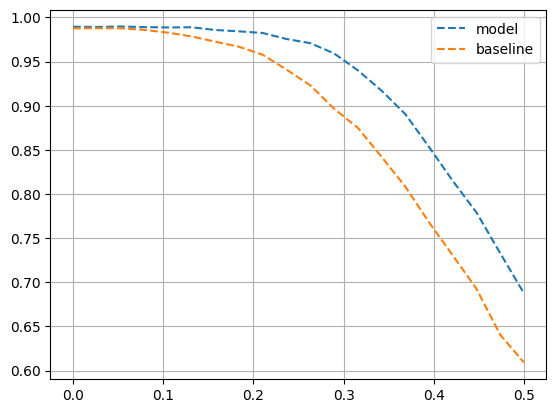

In [ ]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## MNIST-C

In this section, we are to exame the model and the baseline model on the [MNIST-C](https://github.com/google-research/mnist-c) dataset, which was designed for evaluating the robustness of models trained on MNIST dataset.

We have downloaded the ZIP file from [here](https://zenodo.org/records/3239543), and unpacked into the `data` folder.

In [ ]:
!wget https://zenodo.org/records/3239543/files/mnist_c.zip
!unzip -f mnist_c.zip
!mkdir -p data
!mv mnist_c data/
!rm mnist_c.zip

--2024-03-23 05:01:57--  https://zenodo.org/records/3239543/files/mnist_c.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246661575 (235M) [application/octet-stream]
Saving to: ‘mnist_c.zip’

mnist_c.zip         100%[===================>] 235.23M   134MB/s    in 1.8s    

2024-03-23 05:01:59 (134 MB/s) - ‘mnist_c.zip’ saved [246661575/246661575]

Archive:  mnist_c.zip
mv: cannot stat 'mnist_c': No such file or directory


In [22]:
print('noise type : model accuracy : baseline accuracy : exceed')
mnist_c_folder = 'data/mnist_c'
for noise_type in os.listdir(mnist_c_folder):
    x_eval = np.load(os.path.join(mnist_c_folder, f'{noise_type}/test_images.npy'))
    y_eval = np.load(os.path.join(mnist_c_folder, f'{noise_type}/test_labels.npy'))

    x_eval = x_eval.astype('float32') / 255.0
    y_eval = y_eval.astype('float32')

    model_eval = accuracy_score(y_eval, tf.argmax(model(x_eval), axis=1))
    baseline_eval = accuracy_score(y_eval, tf.argmax(baseline_model(x_eval), axis=1))
    exceed = model_eval - baseline_eval

    print(f'{noise_type} : {model_eval*100:.1f}% : {baseline_eval*100:.1f}% : {exceed*100:.1f}%')

noise type : model accuracy : baseline accuracy : exceed
identity : 98.9% : 98.8% : 0.2%
shear : 96.2% : 96.2% : 0.0%
motion_blur : 93.5% : 93.2% : 0.3%
spatter : 97.8% : 97.4% : 0.4%
brightness : 97.6% : 92.4% : 5.2%
rotate : 90.9% : 90.5% : 0.4%
canny_edges : 82.1% : 80.6% : 1.4%
scale : 90.2% : 91.7% : -1.5%
dotted_line : 97.6% : 95.4% : 2.2%
shot_noise : 97.6% : 96.5% : 1.2%
translate : 46.6% : 47.0% : -0.4%
glass_blur : 93.8% : 90.0% : 3.9%
fog : 95.8% : 87.6% : 8.2%
zigzag : 87.8% : 85.8% : 1.9%
stripe : 92.1% : 93.1% : -1.0%
impulse_noise : 93.2% : 82.0% : 11.2%


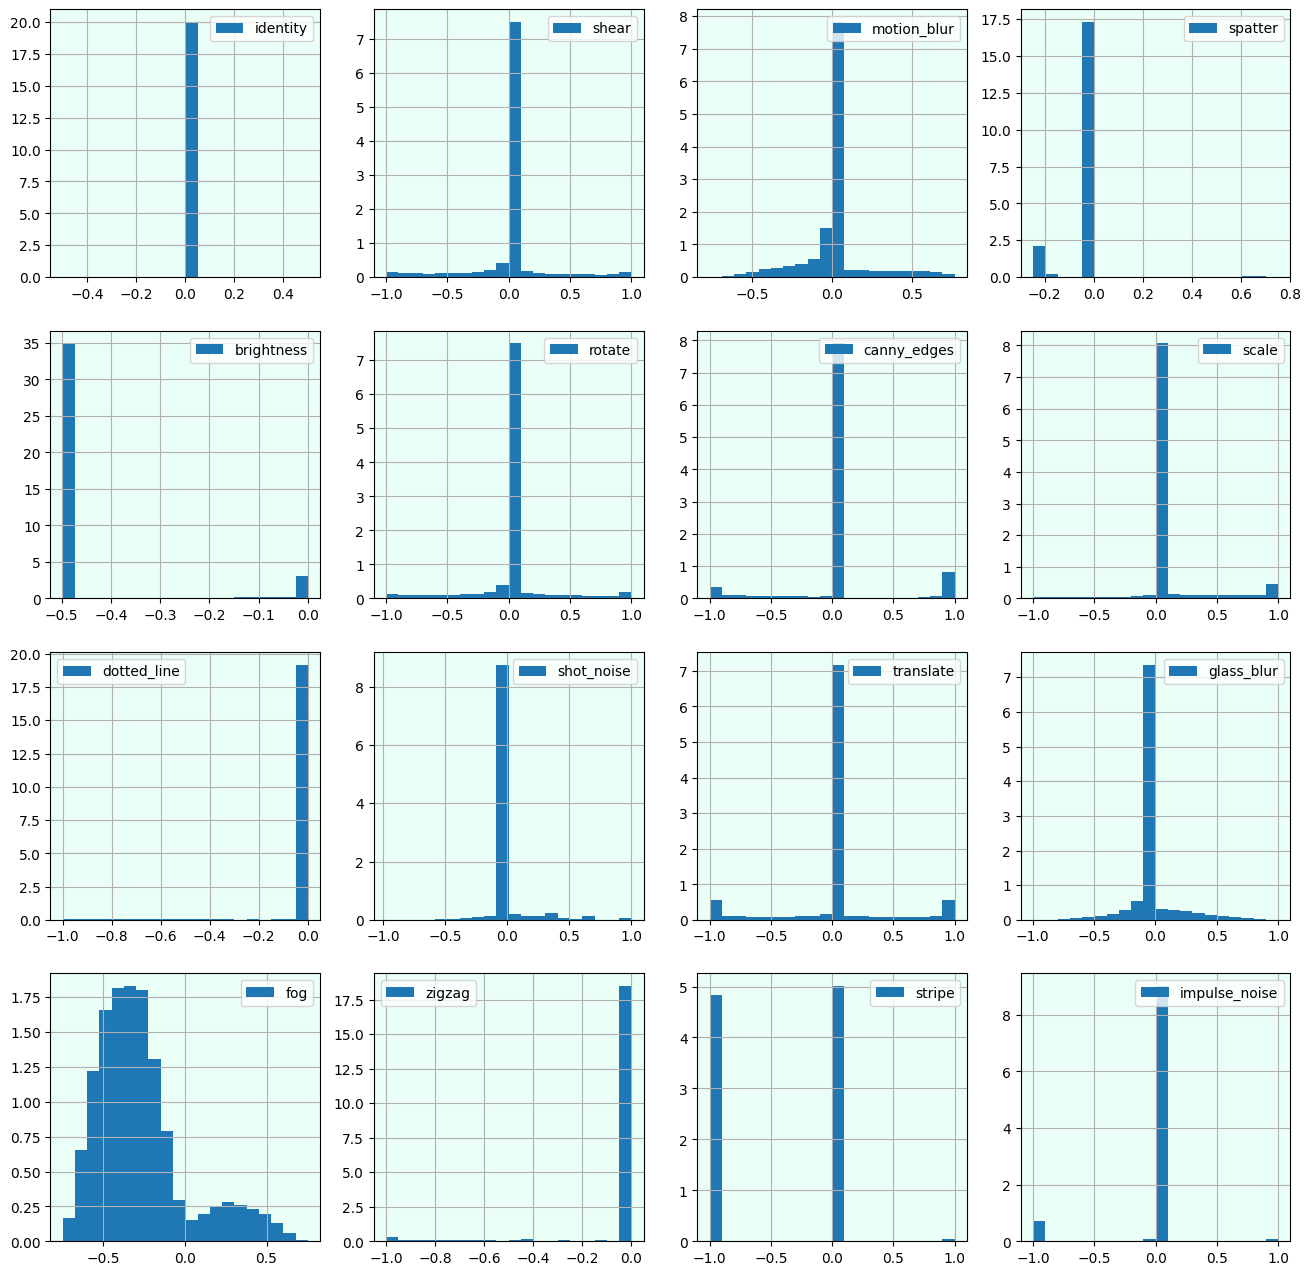

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, noise_type in enumerate(os.listdir('data/mnist_c')):
    j = i // 4
    k = i % 4
    ax = axs[j][k]

    x_eval = np.load(f'data/mnist_c/{noise_type}/test_images.npy')
    x_eval = x_eval.astype('float32') / 255.0

    diff = (x_test - x_eval).reshape([-1])
    ax.hist(diff, 20, label=noise_type, density=True)
    ax.legend()
    ax.grid()
    ax.set_facecolor('#eafff5')

plt.show()

## Conclusion

- We have trained a simple feed-forward neural network on the MNIST dataset by minimizing loss gradients.
- The performance examed by accuracy approaches the baseline, which is trained by minimizing loss.
- For simple Gaussian noise, the robustness is greatly out-performs the baseline.
- We also examed more types of noise, using the MNIST-C dataset. We find that the robustness is significant on the types "dotted line" and "inpulse noise". Temporally, there is no hint about when robustness out-performs the baseline.